In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats-2021-task1/BraTS2021_00495.tar
/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar
/kaggle/input/brats-2021-task1/BraTS2021_00621.tar


In [ ]:
# unzip the dataset
!tar -xvf /kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar
!tar -xvf /kaggle/input/brats-2021-task1/BraTS2021_00621.tar

./
./.DS_Store
./BraTS2021_00000/
./BraTS2021_00000/BraTS2021_00000_flair.nii.gz
./BraTS2021_00000/BraTS2021_00000_seg.nii.gz
./BraTS2021_00000/BraTS2021_00000_t1.nii.gz
./BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz
./BraTS2021_00000/BraTS2021_00000_t2.nii.gz
./BraTS2021_00002/
./BraTS2021_00002/BraTS2021_00002_flair.nii.gz
./BraTS2021_00002/BraTS2021_00002_seg.nii.gz
./BraTS2021_00002/BraTS2021_00002_t1.nii.gz
./BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz
./BraTS2021_00002/BraTS2021_00002_t2.nii.gz
./BraTS2021_00003/
./BraTS2021_00003/BraTS2021_00003_flair.nii.gz
./BraTS2021_00003/BraTS2021_00003_seg.nii.gz
./BraTS2021_00003/BraTS2021_00003_t1.nii.gz
./BraTS2021_00003/BraTS2021_00003_t1ce.nii.gz
./BraTS2021_00003/BraTS2021_00003_t2.nii.gz
./BraTS2021_00005/
./BraTS2021_00005/BraTS2021_00005_flair.nii.gz
./BraTS2021_00005/BraTS2021_00005_seg.nii.gz
./BraTS2021_00005/BraTS2021_00005_t1.nii.gz
./BraTS2021_00005/BraTS2021_00005_t1ce.nii.gz
./BraTS2021_00005/BraTS2021_00005_t2.nii.gz
./Bra

In [3]:
!pip -q install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.7 MB/s eta 0:00:00:00:0100:01


## View a sample of the dataset

In [24]:
from monai.transforms import (
    Compose, EnsureChannelFirst, Orientation, Spacing,
    NormalizeIntensity, RandFlip, RandRotate90, RandScaleIntensity,
    RandShiftIntensity, RandGaussianNoise, ToTensor, LoadImage
)
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os

In [8]:
loader = LoadImage(image_only=False)
image, meta_data = loader("/kaggle/working/BraTS2021_00621_t2.nii.gz")

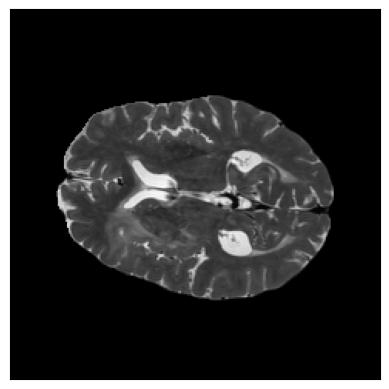

In [9]:
# visualize image
image_slice = image[:, :, 75] #75 slice
plt.imshow(image_slice, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## Create the transformation pipeline

In [57]:
keys = ["flair", "t1", "t1ce", "t2", "seg"]

transform = Compose([
    LoadImaged(keys=keys),
    EnsureChannelFirstd(keys=keys),
    Orientationd(keys=keys, axcodes="RAS"),
    Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    NormalizeIntensityd(keys=keys[:-1], nonzero=True, channel_wise=True),
    RandFlipd(keys=keys, spatial_axis=0, prob=0.5),
    RandRotate90d(keys=keys, prob=0.5),
    RandScaleIntensityd(keys=keys[:-1], factors=0.1, prob=0.5), 
    RandShiftIntensityd(keys=keys[:-1], offsets=0.1, prob=0.5), 
    RandGaussianNoised(keys=keys[:-1], prob=0.2), 
    ToTensord(keys=keys)
])

## Define Custom Dataloader

In [102]:
class BRATSDataset(Dataset):
    def __init__(self, data_dir, transform=None, mode="train", patient_id=None):
        self.data_dir = data_dir
        self.mode = mode
        self.transform = transform

        if patient_id:
            self.patient_id = patient_id
        else:
            self.patient_id = [d for d in os.listdir(data_dir) 
                               if os.path.isdir(os.path.join(data_dir, d))]

    def __len__(self):
        return len(self.patient_id)

    def __getitem__(self, idx):
        pid = self.patient_id[idx]
        base_path = os.path.join(self.data_dir, pid)

        item = {
            "flair": os.path.join(base_path, f"{pid}_flair.nii.gz"),
            "t1": os.path.join(base_path, f"{pid}_t1.nii.gz"),
            "t1ce": os.path.join(base_path, f"{pid}_t1ce.nii.gz"),
            "t2": os.path.join(base_path, f"{pid}_t2.nii.gz"),
        }

        if self.mode == "train":
            item["seg"] = os.path.join(base_path, f"{pid}_seg.nii.gz")

        if self.transform:
            item = self.transform(item)

        return item

In [103]:
data_dir = "/kaggle/working/"
dataset = BRATSDataset(data_dir, mode='train',transform=transform)

In [107]:
dataloader = DataLoader(dataset=dataset, batch_size=2, shuffle=True)

In [108]:
for batch in dataloader:
    print(type(batch))
    print(len(batch))
    break

<class 'dict'>
5
